# Linear regression demo

Running through a intro to regression in python using a tutorial from [Understanding Multiple Linear Regression](https://medium.com/towards-artificial-intelligence/understanding-multiple-linear-regression-1b4a5b939f5a)

This tutorial goes through it step by step, another notebook will try to use the statsmodels library to achieve the same goal.

In [108]:
# importing required libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pylab as pl
import numpy as np

In [109]:
# First Let's import our Data set
data = "https://raw.githubusercontent.com/Blackman9t/Machine_Learning/master/Original_2000_2014_Fuel_Consumption_Ratings.csv"

# Next let's define additional representation of null values 
# To help us select all possible null values in case they exist
missing_data = ["n/a","na","--","?","non","Non","None"]

In [110]:
fuel_df = pd.read_csv(data, na_values=missing_data)
#Next let's print out the first five rows
fuel_df.head()

,MODEL_YEAR,MAKE,MODEL,VEHICLE_CLASS,ENGINE_SIZE(L),CYLINDERS,TRANSMISSION,FUEL_TYPE,FUEL_CONSUMPTION_CITY(L/100km),HWY_(L/100km),COMB_(L/100km),COMB_(mpg),CO2_EMISSIONS(g/km)
0,2000,ACURA,1.6EL,COMPACT,1.6,4,A4,X,9.2,6.7,8.1,35,186
1,2000,ACURA,1.6EL,COMPACT,1.6,4,M5,X,8.5,6.5,7.6,37,175
2,2000,ACURA,3.2TL,MID-SIZE,3.2,6,AS5,Z,12.2,7.4,10.0,28,230
3,2000,ACURA,3.5RL,MID-SIZE,3.5,6,A4,Z,13.4,9.2,11.5,25,264
4,2000,ACURA,INTEGRA,SUBCOMPACT,1.8,4,A4,X,10.0,7.0,8.6,33,198


In [111]:
# Check the shape
fuel_df.shape

(14343, 13)

In [112]:
# Check for missing values
fuel_df.isna().any().all()


False

In [113]:
# Rename some columns to make them more readable.

fuel_df.rename(columns={'FUEL_CONSUMPTION_CITY(L/100km)':'FUEL_CONS_CITY', 
                        'ENGINE_SIZE(L)':'ENGINE_SIZE',
                       'HWY_(L/100km)':'HWY_L100km',
                       'COMB_(L/100km)':'COMB_L100km',
                       'COMB_(mpg)':'COMB_MPG',
                       'CO2_EMISSIONS(g/km)':'CO2_EMISSIONS'},
                       inplace=True)
fuel_df.head(3)

,MODEL_YEAR,MAKE,MODEL,VEHICLE_CLASS,ENGINE_SIZE,CYLINDERS,TRANSMISSION,FUEL_TYPE,FUEL_CONS_CITY,HWY_L100km,COMB_L100km,COMB_MPG,CO2_EMISSIONS
0,2000,ACURA,1.6EL,COMPACT,1.6,4,A4,X,9.2,6.7,8.1,35,186
1,2000,ACURA,1.6EL,COMPACT,1.6,4,M5,X,8.5,6.5,7.6,37,175
2,2000,ACURA,3.2TL,MID-SIZE,3.2,6,AS5,Z,12.2,7.4,10.0,28,230


In this example we are trying to predict the CO2 emissions based on the other input variables. E.g. Engine size, make, model etc.

So to work out which variables to put into our "feature matrix" (the matrix of independent variables), we need to work out which variables have a correlation with the dependent variable - CO2 emissions. 

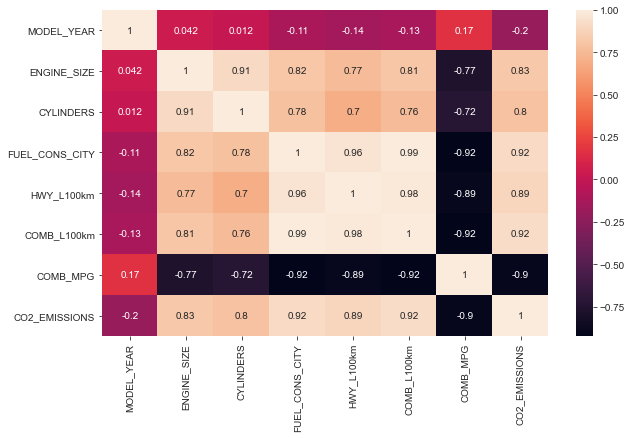

In [114]:
# Let's plot the correlation of the data set using a heatmap from seaborn library.

corr_data = fuel_df.corr()
plt.figure(figsize=(10, 6)) # this is literally just the size of the plot, nothing to do with the dimensions. 
sns.set_style('ticks')
sns.heatmap(corr_data, annot=True)
plt.show()

# This plot is a plot of each variables correlation with one another. Hence the 1 down the main diagonal. It gives us an idea of which variables are going to affect the dependent variable. 

In [115]:
# Find a list of the strongly correlated variables with co2 emissions. 
strong_pos = corr_data.CO2_EMISSIONS > 0.79
strong_neg = corr_data.CO2_EMISSIONS < -0.79
strong_corr = corr_data[strong_pos | strong_neg]
strong_corr = strong_corr.drop(columns=["MODEL_YEAR", "ENGINE_SIZE", "CYLINDERS", "FUEL_CONS_CITY",
"HWY_L100km", "COMB_L100km", "COMB_MPG"])
strong_corr

# A list of the correlation with CO2 emissions.

,CO2_EMISSIONS
ENGINE_SIZE,0.826281
CYLINDERS,0.795518
FUEL_CONS_CITY,0.917137
HWY_L100km,0.891159
COMB_L100km,0.917716
COMB_MPG,-0.899566
CO2_EMISSIONS,1.000000


### Multi colinearity
Eyeballing the heatmap shows that some variables have strong correlations with one another. This can cause a problem. For example, Fuel_Cons_City and Comb_L/100. 

Severe cases of multi-colinearity can cause regression estimates to be innaccurate. Or the coefficients to switch signs which distorts the model. 

We can measure the colinearity of the variables by using something called the variance-inflation-factor (VIF). If the score is 1, then it is ok, between 1 and 5 is generally accpetable but > 5 suggests that the variable is redundant and should be dropped. 

In [116]:
# Looking at the colinearity of those 6 highly correlated variables. 
data = fuel_df[['ENGINE_SIZE','CYLINDERS','FUEL_CONS_CITY','COMB_MPG', 'HWY_L100km', 'COMB_L100km']]
data.head()


,ENGINE_SIZE,CYLINDERS,FUEL_CONS_CITY,COMB_MPG,HWY_L100km,COMB_L100km
0,1.6,4,9.2,35,6.7,8.1
1,1.6,4,8.5,37,6.5,7.6
2,3.2,6,12.2,28,7.4,10.0
3,3.5,6,13.4,25,9.2,11.5
4,1.8,4,10.0,33,7.0,8.6


In [117]:
# Standardize the features within this model. Using the average and standard deviation. 

def standardize(data_features):
    data_features = (data_features - data_features.mean()) / data_features.std()
    return data_features

std_data = data.apply(standardize, axis=0)
std_data.head()



,ENGINE_SIZE,CYLINDERS,FUEL_CONS_CITY,COMB_MPG,HWY_L100km,COMB_L100km
0,-1.429815,-1.119788,-1.046373,1.019024,-0.902562,-0.998244
1,-1.429815,-1.119788,-1.243575,1.285557,-0.987882,-1.166213
2,-0.209256,0.006162,-0.201224,0.086159,-0.603942,-0.359962
3,0.019599,0.006162,0.136836,-0.313640,0.163939,0.143945
4,-1.277245,-1.119788,-0.821000,0.752491,-0.774582,-0.830275


In [118]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(std_data.values, i) for i in range(std_data.shape[1])]
vif["features"] = std_data.columns
vif

,VIF_Factor,features
0,6.947478,ENGINE_SIZE
1,6.338015,CYLINDERS
2,1818.224119,FUEL_CONS_CITY
3,6.832871,COMB_MPG
4,533.988354,HWY_L100km
5,4184.504559,COMB_L100km


In [119]:
# Dropping variables with extreme colinearity scores
std_data.drop(['COMB_L100km','HWY_L100km','FUEL_CONS_CITY'], axis=1, inplace=True)

In [120]:
# Repeat to calculate the VIF for the remaining variables.
vif = pd.DataFrame()
vif["VIF_Factor"] = [variance_inflation_factor(std_data.values, i) for i in range(std_data.shape[1])]
vif["features"] = std_data.columns
vif

,VIF_Factor,features
0,6.566240,ENGINE_SIZE
1,5.570778,CYLINDERS
2,2.474966,COMB_MPG


Although these are greater than 5 they are moderate compared to the rest and dropping the > 5 values would result in a single variable LR model. 


We need to insert a column of 1s to be mutplied to create the bias unit b0.

In [135]:
# Save the un-standardized data with moderate VIF attributes as X
X = data[['ENGINE_SIZE','CYLINDERS','COMB_MPG']]
# Define a column of ones, the length of X
ones = np.ones(len(X), dtype= 'int8')
# Insert The column of ones to the first position of X
X.insert(0, 'Ones', ones)
# Display first 5 rows of X
X.head()


,Ones,ENGINE_SIZE,CYLINDERS,COMB_MPG
0,1,1.6,4,35
1,1,1.6,4,37
2,1,3.2,6,28
3,1,3.5,6,25
4,1,1.8,4,33


In [136]:
# Now we define target matrix y(an m * 1 column vector)
y = fuel_df.CO2_EMISSIONS
y.head()

0    186
1    175
2    230
3    264
4    198
Name: CO2_EMISSIONS, dtype: int64

## Training and test data sets 

Split into two data sets so we can evaluate the model. 

In [137]:
# Import train_test_split for splitting the data set
from sklearn.model_selection import train_test_split
# split the data set into training and testing sets.
X, X_test, y, y_test = train_test_split(X, y, test_size=0.25, shuffle=True)
# Display the shapes of each split
print('X shape is:',X.shape)
print('y shape is:',y.shape)
print('X_test shape is:',X_test.shape)
print('y_test shape is:',y_test.shape)

X shape is: (10757, 4)
y shape is: (10757,)
X_test shape is: (3586, 4)
y_test shape is: (3586,)


## Defining the gradient: least squares estimate

To define the gradient of the regression line we will use the least squares estimate. 

The LSE formula for calculating the b coefficients (gradients) is b = (X'X)^-1 X'Y

In [138]:
# Step 1: define the x-transpose matrix. (X')

# First we convert X and X_test, y, y_test to Numpy arrays for ease of computing
X = X.values
X_test = X_test.values
y = y.values
y_test = y_test.values
# Next we define X_trans, the Transpose of X matrix
X_trans = X.transpose()
print('X-Trans shape:',X_trans.shape)

X-Trans shape: (4, 10757)


In [139]:
# Step 2: multiply X-transposed by X. (X'X)
# Post-multiply X_trans by X
X_trans_X = np.matmul(X_trans, X)
# Print out the shape of X_trans_X
print('X_Trans_X shape:',X_trans_X.shape)
print(X_trans_X)

X_Trans_X shape: (4, 4)
[[  10757.     37474.     64587.    293840.  ]
 [  37474.    149160.22  247853.1   941052.8 ]
 [  64587.    247853.1   422009.   1659494.  ]
 [ 293840.    941052.8  1659494.   8641240.  ]]


In [140]:
# Step 3: define the inverse of X-transposed post-multiplied by matrix X. (X’X)^-1

# Import inv from numpy.linear algebra
from numpy.linalg import inv
# define X_trans_X_inv
X_trans_X_inv = inv(X_trans_X)
# Print the shape of X_trans_X_inv
print("Shape of X_trans_X_inv is",X_trans_X_inv.shape)
print(X_trans_X_inv)

Shape of X_trans_X_inv is (4, 4)
[[ 8.98934371e-03 -5.11363484e-04 -3.77467561e-04 -1.77498086e-04]
 [-5.11363484e-04  3.56067030e-04 -1.90987052e-04  1.52898238e-05]
 [-3.77467561e-04 -1.90987052e-04  1.63578519e-04  2.22032905e-06]
 [-1.77498086e-04  1.52898238e-05  2.22032905e-06  4.05993625e-06]]


In [142]:
# Step 4: post-multiply inverse of X-transposed-X by X-transposed. (X’X)^-1*X’

# Let's Post-multiply X_trans_X_inv by X_trans
X_trans_X_inv_X_trans = np.matmul(X_trans_X_inv, X_trans)
# Let's print the shape
print("Shape of X_trans_X_inv_X_trans is",X_trans_X_inv_X_trans.shape)

Shape of X_trans_X_inv_X_trans is (4, 10757)


In [143]:
# Step 5: post-multiply (X’X)^-1X’ by matrix y to derive the full formula (X’X)^-1X’Y

# Matrix b or coefficients defined as:
b = np.matmul(X_trans_X_inv_X_trans, y)
# Let's print the shape of b
print('Shape of matrix b or coefficients is:', b.shape)
# Print the values of b
print(b)

Shape of matrix b or coefficients is: (4,)
[320.04796314   8.12525609   6.01430662  -4.95660498]


These results are actually different to the values achieved in the article. But they are still close. So it is likely to be small differences from the random test/train split.

In [144]:
# Let’s use our matrix algebra model coefficients to predict the test data set.
# Let's define a simple method for prediction
def predict(x):
    """ takes a row of test data and predicts it
    and returns the summed value of the observation"""
    x = list(x)
    
    x = x[0]*b[0] + x[1]*b[1] + x[2]*b[2] + x[3]*b[3]
    
    return x

In [146]:
# turn the test dataframe into a dataframe to be evaluated. From the train/test split.
X_eval = pd.DataFrame(X_test)


In [147]:
# Apply the model to the test dataset, and save as a list. 
y_hat = np.ceil(X_eval.apply(predict, axis=1).values)
print(y_hat)

[251. 343. 236. ... 283. 251. 221.]


## Evaluating the model. 
Now let's evaluate the model to see how accurate it is. 

In [148]:
# First import metrics from sklearn
from sklearn.metrics import mean_squared_error, r2_score

In [149]:
MSE = mean_squared_error(y_test, y_hat)
RMSE = MSE**0.5
# Let's print out the MSE and RMSE
print(MSE)
print(RMSE)


480.26938092582265
21.915049188304884


These are much higher than in the article. Somewhere the model has got mixed up. Will try to debug.

In [150]:
# Now compute r squared value to find the fit evaluation.fuel_df
# First we find the range of the target variable, y
y_range = y_test.max() - y_test.min()
# Then we compute the RMSE as a percentage of the range of y
error_margin = error_margin = (RMSE / y_range) * 100
# Next we compute the r2_score
r2_score = r2_score(y_test, y_hat)
# Let's print out the error_margin and r2_score
print(error_margin)
print(r2_score)

5.037942342139054
0.8576028500961941


This is a reasonable fit. 0.85.

I will try a statsmodels version and see what happens there. 